# Import Libraries

In [17]:
import torch
print(torch.__version__)
import torchvision
import torch.nn as nn

import os
import sys
import time

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

2.6.0


# GPU/CUDA setup

In [ ]:
# if torch.cuda.is_available():
#     print("CUDA enabled!")
# device = 'cuda:0'
# os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(f'{i}' for i in range(1))

In [23]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Autoencoder Helpers

In [24]:
"""
Adopted from @author Oscar Li

Source: https://github.com/OscarcarLi/PrototypeDL
"""
def makedirs(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)

def list_of_distances(X, Y):
    '''
    Given a list of vectors, X = [x_1, ..., x_n], and another list of vectors,
    Y = [y_1, ... , y_m], we return a list of vectors
            [[d(x_1, y_1), d(x_1, y_2), ... , d(x_1, y_m)],
             ...
             [d(x_n, y_1), d(x_n, y_2), ... , d(x_n, y_m)]],
    where the distance metric used is the sqared euclidean distance.
    The computation is achieved through a clever use of broadcasting.
    '''
    XX = torch.reshape(list_of_norms(X), shape=(-1, 1))

    YY = torch.reshape(list_of_norms(Y), shape=(1, -1))
    output = XX + YY - 2 * torch.matmul(X, torch.transpose(Y, 0, 1))
    return output

def list_of_norms(X):
    '''
    X is a list of vectors X = [x_1, ..., x_n], we return
        [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
    function is the squared euclidean distance.
    '''
    return torch.sum(torch.pow(X, 2),dim=1)

def print_and_write(str, file):
    '''
    print str to the console and also write it to file
    '''
    print(str)
    file.write(str + '\n')



# Network Modules

In [25]:
class EncoderLayer(nn.Module):
    def __init__(self, in_channels=1, n_maps=32, out_channels=10, n_layers=4):
        super(EncoderLayer, self).__init__()
        
        el = []
        el += [ConvLayer(in_channels, n_maps, stride=2, padding=1)]
        for i in range(0, n_layers-2):
            el += [ConvLayer(n_maps, n_maps, stride=2, padding=1)]   
        el += [ConvLayer(n_maps, out_channels, stride=2, padding=1)]

        self.encoder = nn.Sequential(*el)

    def forward(self, x):
        return self.encoder(x)

class DecoderLayer(nn.Module):
    def __init__(self, in_channels=10, n_maps=32, out_channels=1, out_shapes=[], n_layers=4):
        super(DecoderLayer, self).__init__()

        dl = []
        dl += [DeConvLayer(in_channels, n_maps, out_shape=out_shapes[-1], stride=2, padding=1, output_padding=1)]
        for i in range(1, n_layers-1):
            dl += [DeConvLayer(n_maps, n_maps, out_shape=out_shapes[-(i+1)], stride=2, padding=1, output_padding=1)]
        dl += [DeConvLayer(n_maps, out_channels, out_shape=out_shapes[-n_layers], stride=2, padding=1, 
                           output_padding=1, activation=nn.Sigmoid)]

        self.decoder = nn.Sequential(*dl)

    def forward(self, x):
        return self.decoder(x)

class PrototypeLayer(nn.Module):
    def __init__(self, in_channels=10, n_prototypes=15):
        super(PrototypeLayer, self).__init__()

        self.prototype_distances = torch.rand(n_prototypes, in_channels, requires_grad=True).to(device)

    def forward(self, x):
        return list_of_distances(x, self.prototype_distances)

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, padding=1, activation=nn.ReLU):
        super(ConvLayer, self).__init__()
        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3,
                             stride=stride, padding=padding)
        self.activation = activation()

    def forward(self, x):
        self.in_dim = x.shape[-2:]
        return self.activation(self.conv(x)) 

class DeConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, out_shape, stride=2, padding=1, output_padding=1, activation=nn.ReLU):
        super(DeConvLayer, self).__init__()
        self.out_shape = out_shape
        self.dconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, 
                                        stride=stride, padding=padding, output_padding=output_padding)
        self.activation = activation()

    def forward(self, x):
        out_convt = self.dconv(x)
        if (out_convt.shape[-2:][0] != self.out_shape[0]) & (out_convt.shape[-2:][1] != self.out_shape[1]):
            out_convt = out_convt[:,:,(out_convt.shape[-2:][0] - self.out_shape[0]):,
                                 (out_convt.shape[-2:][1] - self.out_shape[1]):]
        return self.activation(out_convt)

class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features=15, out_features=10):
        super(FullyConnectedLayer, self).__init__()

        self.linear = nn.Linear(in_features=in_features, out_features=out_features)

    def forward(self, x):
        return self.linear(x)

class Softmax(nn.Module):
    def __init__(self):
        super(Softmax, self).__init__()

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(x)

# CAE Model definition

In [26]:
class CAEModel(nn.Module):
    def __init__(self, input_shape=(1, 1, 28,28), n_maps=32, n_prototypes=15, n_layers=4, n_classes=10):
        super(CAEModel, self).__init__()

        # add encoder layer
        self.encoder = EncoderLayer(in_channels=input_shape[1], n_maps=n_maps, out_channels=n_classes, n_layers=n_layers)
        
        # add prototype layer
        self.in_channels_prototype = self.encoder.forward(torch.randn(input_shape)).view(-1,1).shape[0]
        self.prototype_layer = PrototypeLayer(in_channels=self.in_channels_prototype, n_prototypes=n_prototypes)

        # add decoder layer
        decoder_out_shapes = []
        for layer in self.encoder.modules():
            if isinstance(layer, ConvLayer):
                decoder_out_shapes += [list(layer.in_dim)]
        self.decoder = DecoderLayer(in_channels=n_classes, n_maps=n_maps, out_channels=input_shape[1], out_shapes=decoder_out_shapes)
        
        # output layer
        # add final fully connected layer
        self.fc = FullyConnectedLayer(in_features=n_prototypes, out_features=n_classes)
        self.feature_vectors = None

    def forward(self, x):
        encoder_out = self.encoder(x)
        self.feature_vectors = encoder_out
        prototype_out = self.prototype_layer(encoder_out.view(-1,self.in_channels_prototype))
        fc_out = self.fc(prototype_out)
        return fc_out

# Data Processing

In [27]:
"""
Adopted from @author Oscar Li

Source: https://github.com/OscarcarLi/PrototypeDL
"""
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def batch_elastic_transform(images, sigma, alpha, height, width, random_state=None):
    '''
    this code is borrowed from chsasank on GitHubGist
    Elastic deformation of images as described in [Simard 2003].
    
    images: a two-dimensional numpy array; we can think of it as a list of flattened images
    sigma: the real-valued variance of the gaussian kernel
    alpha: a real-value that is multiplied onto the displacement fields
    
    returns: an elastically distorted image of the same shape
    '''
    assert len(images.shape) == 2
    # the two lines below ensure we do not alter the array images
    e_images = np.empty_like(images)
    e_images[:] = images
    
    e_images = e_images.reshape(-1, height, width)
    
    if random_state is None:
        random_state = np.random.RandomState(None)
    x, y = np.mgrid[0:height, 0:width]
    
    for i in range(e_images.shape[0]):
        
        dx = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode='constant') * alpha
        dy = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode='constant') * alpha
        indices = x + dx, y + dy
        e_images[i] = map_coordinates(e_images[i], indices, order=1)

    return e_images.reshape(-1, height*width)

/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_4137/1429368971.py:7: DeprecationWarning: Please import `map_coordinates` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import map_coordinates
/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_4137/1429368971.py:8: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


# MINIST Data Loader

In [28]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# function to load and return train and val multi-process iterator over the MNIST dataset.

def get_train_val_loader(data_dir, batch_size, random_seed, augment=False, val_size=0.2, 
                         shuffle=True, show_sample=False, num_workers=0, pin_memory=True):

    # load the dataset
    train_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=transforms.ToTensor())
    val_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=transforms.ToTensor())

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(val_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    # create data iterator
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, 
                                               num_workers=num_workers, pin_memory=pin_memory)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, 
                                             num_workers=num_workers, pin_memory=pin_memory)
    return (train_loader, val_loader)

# function to load and return a multi-process test iterator over the MNIST dataset.
def get_test_loader(data_dir, 
                    batch_size,
                    shuffle=True,
                    num_workers=0,
                    pin_memory=True):

    dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transforms.ToTensor())
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, 
                                              num_workers=num_workers, pin_memory=pin_memory)
    return data_loader

# The directory to save the model

In [30]:
model_folder = os.path.join(os.getcwd(), "saved_model", "mnist_model", "mnist_cae_1")
makedirs(model_folder)
img_folder = os.path.join(model_folder, "img")
makedirs(img_folder)
model_filename = "mnist_cae"

# console_log is the handle to a text file that records the console output
log_folder=os.path.join(model_folder, "log")
makedirs(log_folder)
console_log = open(os.path.join(log_folder, "console_log.txt"), "w+")

# Model parameters

In [31]:
# training parameters
learning_rate = 0.002
training_epochs = 100 #1500
batch_size = 250              # the size of a minibatch
test_display_step = 100       # how many epochs we do evaluate on the test set once
save_step = 5                # how frequently do we save the model to disk

# elastic deformation parameters
sigma = 4
alpha =20

# lambda's are the ratios between the four error terms
lambda_class = 20
lambda_ae = 1
lambda_1 = 1            # 1 and 2 here corresponds to the notation we used in the paper
lambda_2 = 1

# input data parameters
input_height = 28         # MNIST data input shape
input_width = input_height
n_input_channel = 1       # the number of color channels; for MNIST is 1.
input_size = input_height * input_width * n_input_channel   # the number of pixels in one input image
input_shape = (1, n_input_channel, input_height, input_height) # input shape to pass in the model
n_classes = 10

# Network Parameters
n_prototypes = 15         # the number of prototypes
n_layers = 4
n_maps = 32

# Load MNIST Data

In [11]:
#you may need to install the following packages in your python environment if it fails to donload data.
#conda install -c conda-forge ipywidgets
#jupyter nbextension enable --py widgetsnbextension
# the following two for jupyter hosted environment
#conda install -n base -c conda-forge widgetsnbextension
#conda install -n <your_environment_name> -c conda-forge ipywidgets


In [32]:
# data load and split parameters
random_seed = 1
n_workers = 0
data_folder = 'data'

# download MNIST data
train_loader, val_loader = get_train_val_loader(data_folder, batch_size, random_seed, augment=False, val_size=0.2,
                           shuffle=True, show_sample=False, num_workers=0, pin_memory=True)
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Get the CAE model

In [33]:
model = CAEModel(input_shape=input_shape, n_maps=n_maps, n_prototypes=n_prototypes, 
                 n_layers=n_layers, n_classes=n_classes).to(device)

# Optimizer setup

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model on MNIST data

################################################################################
Epoch: 0001/0100
batch: 001:   1%|          | 1/192 [00:00<00:30,  6.35it/s]

/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_4137/1429368971.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  e_images[:] = images


batch: 192: 100%|██████████| 192/192 [00:16<00:00, 11.61it/s]
training set errors:	classification error: 1.110190	autoencoder error: 0.047407	error_1: 2.773693	error_2: 4.476790	total error: 29.501688	accuracy: 0.331896
training takes 16.54 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 26.93it/s]
validation set errors:	classification error: 0.948930	autoencoder error: 0.054093	error_1: 2.905820	error_2: 4.414512	total error: 26.353016	accuracy: 0.784417
################################################################################
Epoch: 0002/0100
batch: 192: 100%|██████████| 192/192 [00:16<00:00, 11.83it/s]
training set errors:	classification error: 0.513699	autoencoder error: 0.044499	error_1: 2.303900	error_2: 3.653419	total error: 16.275791	accuracy: 0.845438
training takes 16.23 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 26.75it/s]
validation set errors:	classification error: 0.295939	autoencoder error: 0.051576	error_1: 2.823313	error_2: 4.190804	tota

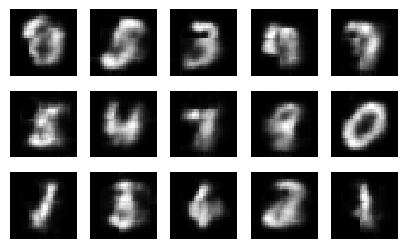

Visualizing encoded and decoded images:


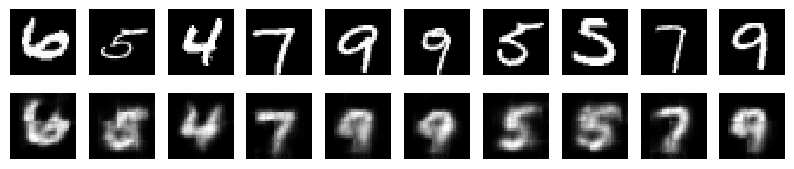

################################################################################
Epoch: 0006/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.90it/s]
training set errors:	classification error: 0.160028	autoencoder error: 0.039925	error_1: 1.220445	error_2: 2.019136	total error: 6.480071	accuracy: 0.950813
training takes 17.61 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 25.19it/s]
validation set errors:	classification error: 0.115522	autoencoder error: 0.045485	error_1: 1.459822	error_2: 2.263614	total error: 6.079353	accuracy: 0.970667
################################################################################
Epoch: 0007/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 11.05it/s]
training set errors:	classification error: 0.211239	autoencoder error: 0.039950	error_1: 1.131017	error_2: 1.997810	total error: 7.393555	accuracy: 0.955646
training takes 17.37 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 25.50it/s]
validation set errors:	clas

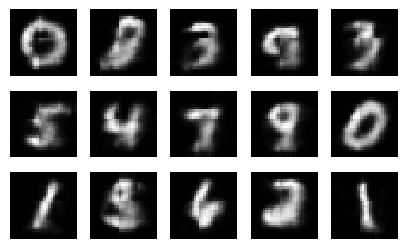

Visualizing encoded and decoded images:


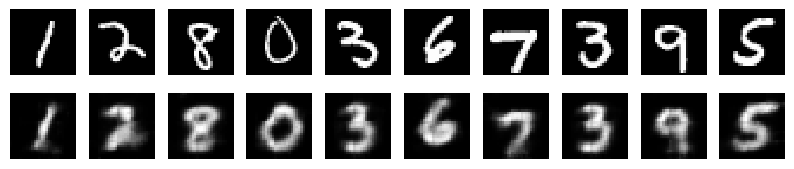

################################################################################
Epoch: 0011/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.87it/s]
training set errors:	classification error: 0.116754	autoencoder error: 0.039432	error_1: 0.908184	error_2: 1.588452	total error: 4.871155	accuracy: 0.964562
training takes 17.67 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.57it/s]
validation set errors:	classification error: 0.048750	autoencoder error: 0.043590	error_1: 0.789231	error_2: 1.522298	total error: 3.330125	accuracy: 0.977083
################################################################################
Epoch: 0012/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.83it/s]
training set errors:	classification error: 0.095856	autoencoder error: 0.038525	error_1: 0.783975	error_2: 1.467042	total error: 4.206665	accuracy: 0.967146
training takes 17.73 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 25.23it/s]
validation set errors:	clas

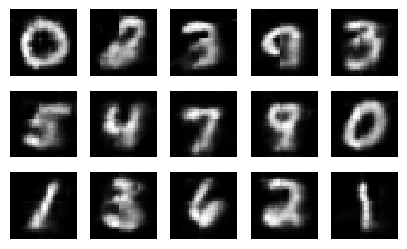

Visualizing encoded and decoded images:


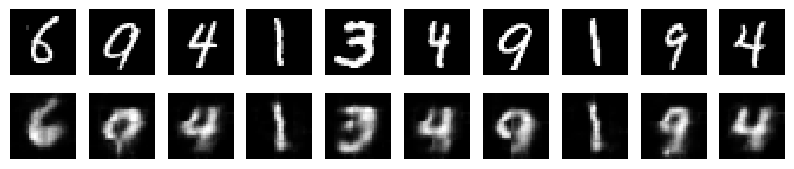

################################################################################
Epoch: 0016/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.82it/s]
training set errors:	classification error: 0.101647	autoencoder error: 0.040016	error_1: 0.662267	error_2: 1.419761	total error: 4.154985	accuracy: 0.970708
training takes 17.74 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 25.54it/s]
validation set errors:	classification error: 0.127525	autoencoder error: 0.043655	error_1: 0.580980	error_2: 1.252728	total error: 4.427863	accuracy: 0.979834
################################################################################
Epoch: 0017/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.90it/s]
training set errors:	classification error: 0.142076	autoencoder error: 0.039522	error_1: 0.662297	error_2: 1.467834	total error: 5.011163	accuracy: 0.971083
training takes 17.62 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 25.05it/s]
validation set errors:	clas

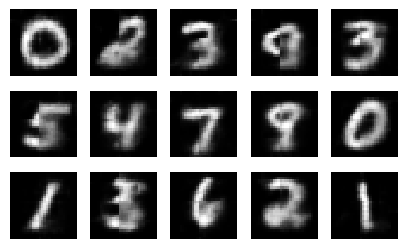

Visualizing encoded and decoded images:


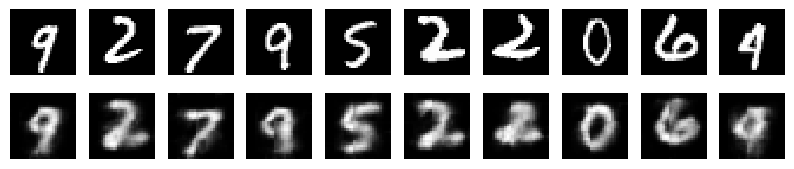

################################################################################
Epoch: 0021/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.75it/s]
training set errors:	classification error: 0.055091	autoencoder error: 0.037925	error_1: 0.498522	error_2: 1.304956	total error: 2.943229	accuracy: 0.974188
training takes 17.86 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 25.10it/s]
validation set errors:	classification error: 0.059521	autoencoder error: 0.046141	error_1: 0.567572	error_2: 1.196486	total error: 3.000617	accuracy: 0.982750
################################################################################
Epoch: 0022/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.73it/s]
training set errors:	classification error: 0.073031	autoencoder error: 0.035588	error_1: 0.482656	error_2: 1.297199	total error: 3.276071	accuracy: 0.973625
training takes 17.90 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.70it/s]
validation set errors:	clas

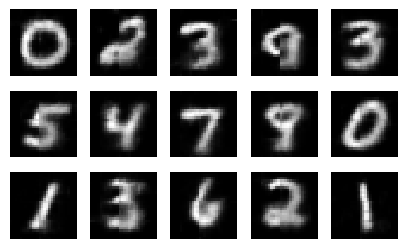

Visualizing encoded and decoded images:


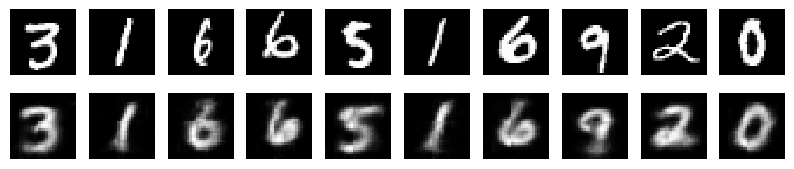

################################################################################
Epoch: 0026/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.34it/s]
training set errors:	classification error: 0.088557	autoencoder error: 0.038468	error_1: 0.392252	error_2: 1.184353	total error: 3.386214	accuracy: 0.976250
training takes 18.57 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.34it/s]
validation set errors:	classification error: 0.050110	autoencoder error: 0.043349	error_1: 0.473361	error_2: 1.124558	total error: 2.643459	accuracy: 0.985250
################################################################################
Epoch: 0027/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.48it/s]
training set errors:	classification error: 0.100148	autoencoder error: 0.039395	error_1: 0.399061	error_2: 1.307425	total error: 3.748832	accuracy: 0.976229
training takes 18.32 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.38it/s]
validation set errors:	clas

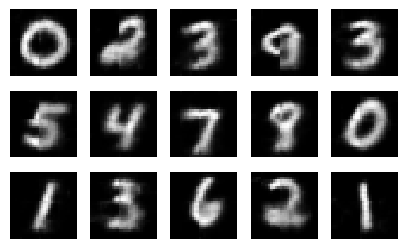

Visualizing encoded and decoded images:


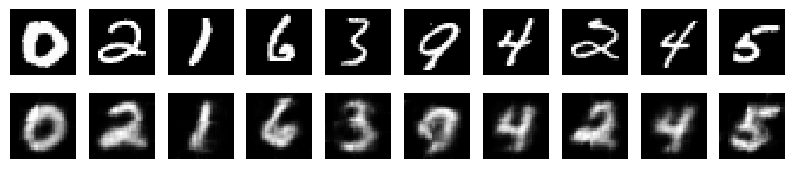

################################################################################
Epoch: 0031/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.47it/s]
training set errors:	classification error: 0.092495	autoencoder error: 0.039987	error_1: 0.451089	error_2: 1.193671	total error: 3.534642	accuracy: 0.977021
training takes 18.34 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.48it/s]
validation set errors:	classification error: 0.057824	autoencoder error: 0.044050	error_1: 0.355373	error_2: 1.129978	total error: 2.685887	accuracy: 0.984750
################################################################################
Epoch: 0032/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.36it/s]
training set errors:	classification error: 0.070157	autoencoder error: 0.040791	error_1: 0.477975	error_2: 1.232025	total error: 3.153937	accuracy: 0.978063
training takes 18.53 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.23it/s]
validation set errors:	clas

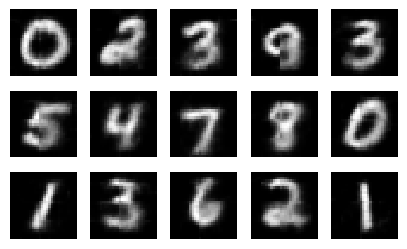

Visualizing encoded and decoded images:


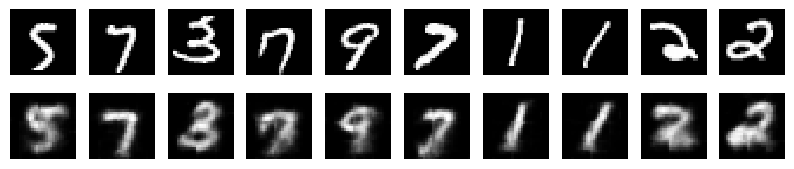

################################################################################
Epoch: 0036/0100
batch: 192: 100%|██████████| 192/192 [00:19<00:00, 10.09it/s]
training set errors:	classification error: 0.075954	autoencoder error: 0.039275	error_1: 0.305172	error_2: 1.109593	total error: 2.973125	accuracy: 0.978667
training takes 19.04 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.11it/s]
validation set errors:	classification error: 0.043522	autoencoder error: 0.044081	error_1: 0.277450	error_2: 0.929227	total error: 2.121198	accuracy: 0.986917
################################################################################
Epoch: 0037/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.28it/s]
training set errors:	classification error: 0.044767	autoencoder error: 0.038550	error_1: 0.313836	error_2: 1.069084	total error: 2.316814	accuracy: 0.978854
training takes 18.67 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.67it/s]
validation set errors:	clas

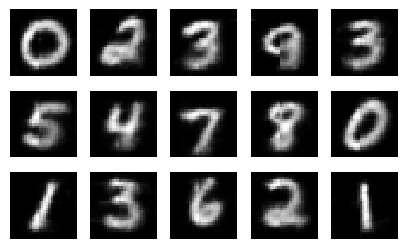

Visualizing encoded and decoded images:


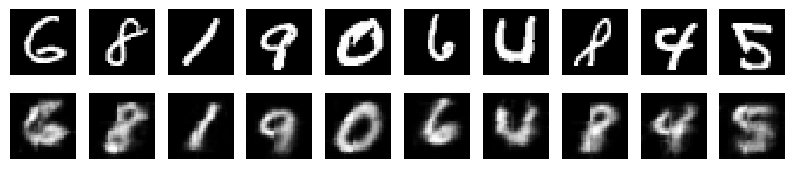

################################################################################
Epoch: 0041/0100
batch: 192: 100%|██████████| 192/192 [00:19<00:00, 10.06it/s]
training set errors:	classification error: 0.086619	autoencoder error: 0.039063	error_1: 0.380864	error_2: 1.069228	total error: 3.221529	accuracy: 0.979500
training takes 19.08 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 21.68it/s]
validation set errors:	classification error: 0.042776	autoencoder error: 0.043840	error_1: 0.351873	error_2: 1.104406	total error: 2.355630	accuracy: 0.986000
################################################################################
Epoch: 0042/0100
batch: 192: 100%|██████████| 192/192 [00:19<00:00,  9.63it/s]
training set errors:	classification error: 0.109429	autoencoder error: 0.038745	error_1: 0.329467	error_2: 1.130911	total error: 3.687696	accuracy: 0.979313
training takes 19.94 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.06it/s]
validation set errors:	clas

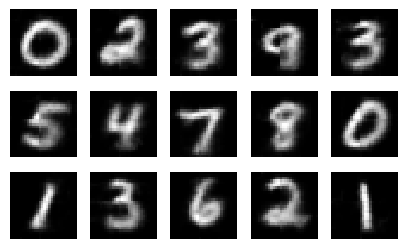

Visualizing encoded and decoded images:


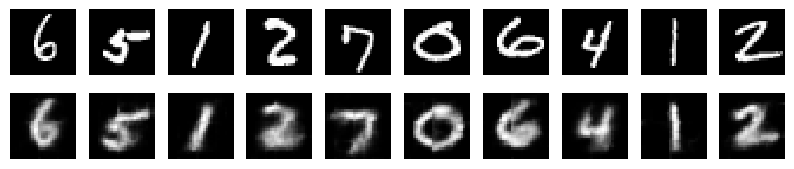

################################################################################
Epoch: 0046/0100
batch: 192: 100%|██████████| 192/192 [00:19<00:00,  9.69it/s]
training set errors:	classification error: 0.047702	autoencoder error: 0.037702	error_1: 0.284180	error_2: 1.051022	total error: 2.326948	accuracy: 0.979813
training takes 19.82 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 22.59it/s]
validation set errors:	classification error: 0.043452	autoencoder error: 0.045242	error_1: 0.307311	error_2: 0.950693	total error: 2.172293	accuracy: 0.985583
################################################################################
Epoch: 0047/0100
batch: 192: 100%|██████████| 192/192 [00:19<00:00, 10.04it/s]
training set errors:	classification error: 0.033949	autoencoder error: 0.037153	error_1: 0.340185	error_2: 1.014667	total error: 2.070987	accuracy: 0.980562
training takes 19.12 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.66it/s]
validation set errors:	clas

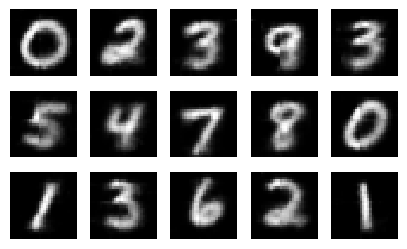

Visualizing encoded and decoded images:


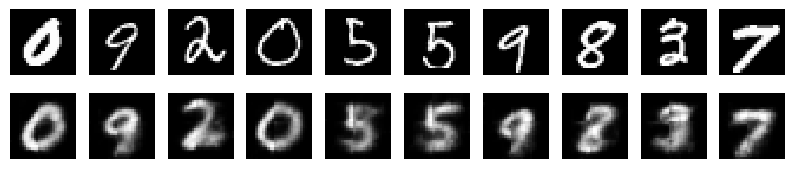

################################################################################
Epoch: 0051/0100
batch: 192: 100%|██████████| 192/192 [00:19<00:00, 10.01it/s]
training set errors:	classification error: 0.070803	autoencoder error: 0.037398	error_1: 0.281052	error_2: 0.989303	total error: 2.723807	accuracy: 0.981063
training takes 19.18 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.95it/s]
validation set errors:	classification error: 0.042021	autoencoder error: 0.044201	error_1: 0.249240	error_2: 0.980454	total error: 2.114308	accuracy: 0.987000
################################################################################
Epoch: 0052/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.16it/s]
training set errors:	classification error: 0.104487	autoencoder error: 0.037849	error_1: 0.341075	error_2: 1.029872	total error: 3.498546	accuracy: 0.980500
training takes 18.89 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.18it/s]
validation set errors:	clas

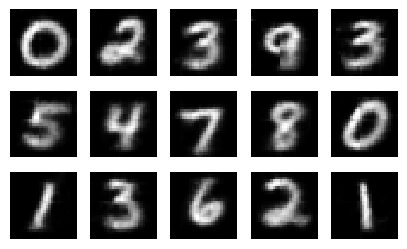

Visualizing encoded and decoded images:


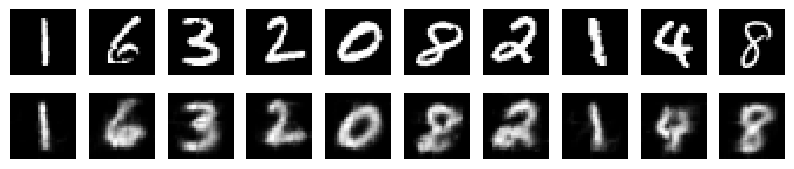

################################################################################
Epoch: 0056/0100
batch: 192: 100%|██████████| 192/192 [00:19<00:00,  9.80it/s]
training set errors:	classification error: 0.053180	autoencoder error: 0.036599	error_1: 0.277928	error_2: 0.950375	total error: 2.328508	accuracy: 0.981146
training takes 19.59 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 24.00it/s]
validation set errors:	classification error: 0.029893	autoencoder error: 0.044137	error_1: 0.251295	error_2: 0.858754	total error: 1.752047	accuracy: 0.987750
################################################################################
Epoch: 0057/0100
batch: 192: 100%|██████████| 192/192 [00:19<00:00,  9.82it/s]
training set errors:	classification error: 0.113268	autoencoder error: 0.037110	error_1: 0.283726	error_2: 0.969557	total error: 3.555753	accuracy: 0.981438
training takes 19.55 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 20.43it/s]
validation set errors:	clas

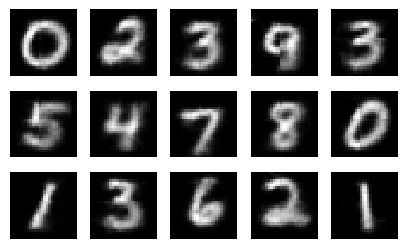

Visualizing encoded and decoded images:


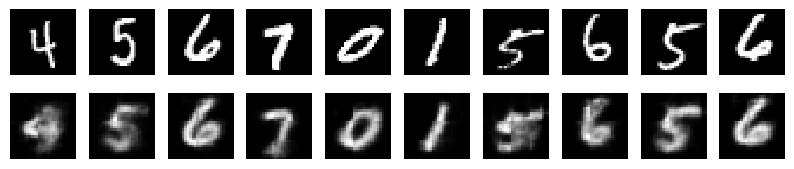

################################################################################
Epoch: 0061/0100
batch: 192: 100%|██████████| 192/192 [00:23<00:00,  8.26it/s]
training set errors:	classification error: 0.046867	autoencoder error: 0.040234	error_1: 0.227062	error_2: 0.981116	total error: 2.185746	accuracy: 0.981583
training takes 23.26 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 20.67it/s]
validation set errors:	classification error: 0.007582	autoencoder error: 0.042116	error_1: 0.250455	error_2: 0.912271	total error: 1.356482	accuracy: 0.989000
################################################################################
Epoch: 0062/0100
batch: 192: 100%|██████████| 192/192 [00:21<00:00,  8.73it/s]
training set errors:	classification error: 0.070430	autoencoder error: 0.037126	error_1: 0.181322	error_2: 0.939646	total error: 2.566696	accuracy: 0.982687
training takes 22.00 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 20.71it/s]
validation set errors:	clas

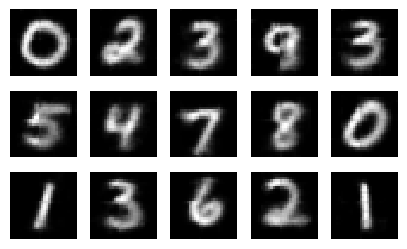

Visualizing encoded and decoded images:


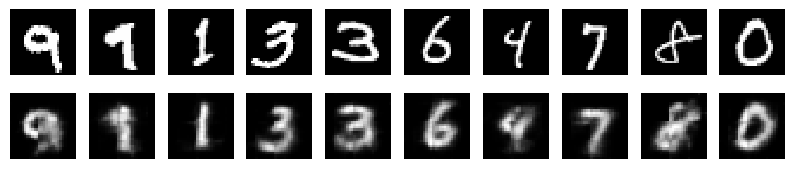

################################################################################
Epoch: 0066/0100
batch: 192: 100%|██████████| 192/192 [00:21<00:00,  9.08it/s]
training set errors:	classification error: 0.069763	autoencoder error: 0.037899	error_1: 0.220025	error_2: 0.973239	total error: 2.626430	accuracy: 0.982250
training takes 21.15 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 21.66it/s]
validation set errors:	classification error: 0.014808	autoencoder error: 0.043624	error_1: 0.239132	error_2: 0.939017	total error: 1.517933	accuracy: 0.987166
################################################################################
Epoch: 0067/0100
batch: 192: 100%|██████████| 192/192 [00:24<00:00,  7.74it/s]
training set errors:	classification error: 0.087889	autoencoder error: 0.039002	error_1: 0.282048	error_2: 0.996669	total error: 3.075496	accuracy: 0.982646
training takes 24.80 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 19.93it/s]
validation set errors:	clas

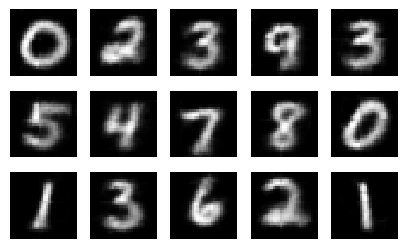

Visualizing encoded and decoded images:


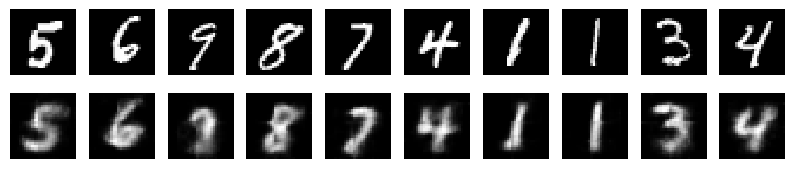

################################################################################
Epoch: 0071/0100
batch: 192: 100%|██████████| 192/192 [00:21<00:00,  9.07it/s]
training set errors:	classification error: 0.121447	autoencoder error: 0.037863	error_1: 0.218702	error_2: 1.018330	total error: 3.703833	accuracy: 0.982813
training takes 21.16 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 22.24it/s]
validation set errors:	classification error: 0.066987	autoencoder error: 0.043913	error_1: 0.221446	error_2: 0.879670	total error: 2.484758	accuracy: 0.986000
################################################################################
Epoch: 0072/0100
batch: 192: 100%|██████████| 192/192 [00:20<00:00,  9.14it/s]
training set errors:	classification error: 0.063536	autoencoder error: 0.039071	error_1: 0.214882	error_2: 0.923174	total error: 2.447846	accuracy: 0.982625
training takes 21.00 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 21.32it/s]
validation set errors:	clas

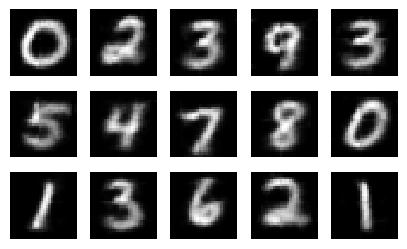

Visualizing encoded and decoded images:


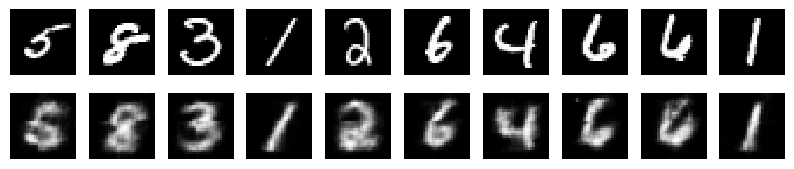

################################################################################
Epoch: 0076/0100
batch: 192: 100%|██████████| 192/192 [00:21<00:00,  8.95it/s]
training set errors:	classification error: 0.018041	autoencoder error: 0.036403	error_1: 0.216116	error_2: 0.912077	total error: 1.525415	accuracy: 0.982813
training takes 21.45 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 17.82it/s]
validation set errors:	classification error: 0.027465	autoencoder error: 0.045048	error_1: 0.247319	error_2: 0.865685	total error: 1.707354	accuracy: 0.989167
################################################################################
Epoch: 0077/0100
batch: 192: 100%|██████████| 192/192 [00:21<00:00,  9.12it/s]
training set errors:	classification error: 0.018635	autoencoder error: 0.038490	error_1: 0.215225	error_2: 0.867690	total error: 1.494100	accuracy: 0.983938
training takes 21.06 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 21.65it/s]
validation set errors:	clas

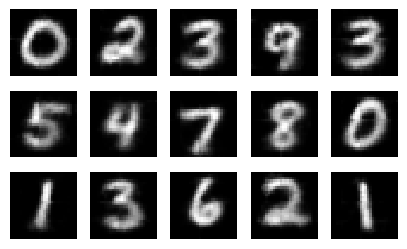

Visualizing encoded and decoded images:


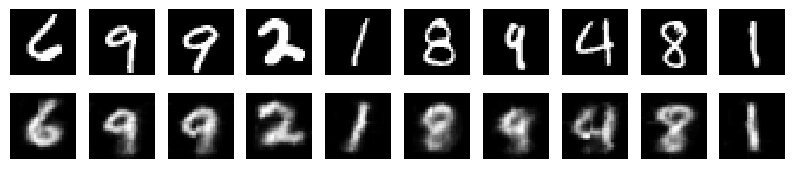

################################################################################
Epoch: 0081/0100
batch: 192: 100%|██████████| 192/192 [00:20<00:00,  9.36it/s]
training set errors:	classification error: 0.043479	autoencoder error: 0.038563	error_1: 0.198072	error_2: 0.912887	total error: 2.019111	accuracy: 0.983771
training takes 20.51 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 21.88it/s]
validation set errors:	classification error: 0.053540	autoencoder error: 0.043503	error_1: 0.196976	error_2: 0.807445	total error: 2.118717	accuracy: 0.988000
################################################################################
Epoch: 0082/0100
batch: 192: 100%|██████████| 192/192 [00:20<00:00,  9.38it/s]
training set errors:	classification error: 0.061448	autoencoder error: 0.037763	error_1: 0.232476	error_2: 0.931711	total error: 2.430914	accuracy: 0.982875
training takes 20.48 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 22.07it/s]
validation set errors:	clas

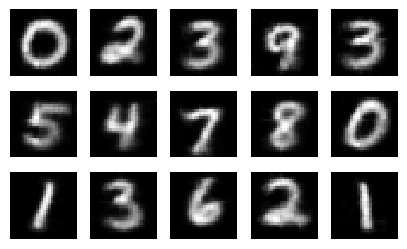

Visualizing encoded and decoded images:


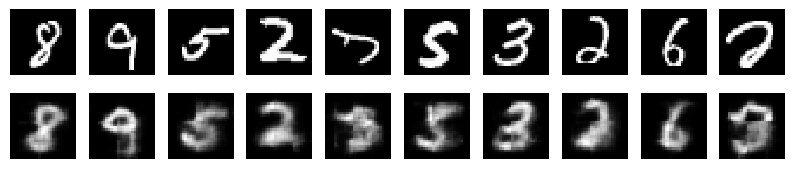

################################################################################
Epoch: 0086/0100
batch: 192: 100%|██████████| 192/192 [00:20<00:00,  9.36it/s]
training set errors:	classification error: 0.042373	autoencoder error: 0.038185	error_1: 0.238605	error_2: 0.862264	total error: 1.986519	accuracy: 0.983896
training takes 20.52 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 21.45it/s]
validation set errors:	classification error: 0.018089	autoencoder error: 0.042539	error_1: 0.200312	error_2: 0.765341	total error: 1.369980	accuracy: 0.988167
################################################################################
Epoch: 0087/0100
batch: 192: 100%|██████████| 192/192 [00:20<00:00,  9.22it/s]
training set errors:	classification error: 0.137027	autoencoder error: 0.038094	error_1: 0.203489	error_2: 0.858791	total error: 3.840913	accuracy: 0.983125
training takes 20.82 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 19.95it/s]
validation set errors:	clas

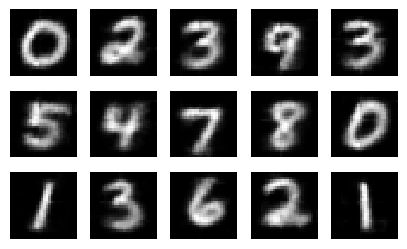

Visualizing encoded and decoded images:


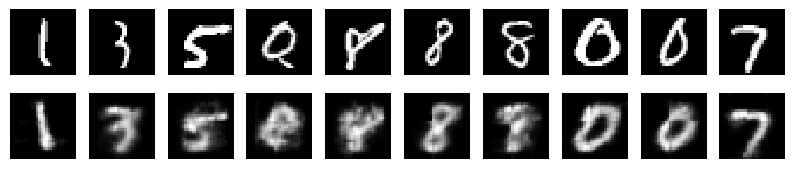

################################################################################
Epoch: 0091/0100
batch: 192: 100%|██████████| 192/192 [00:21<00:00,  9.00it/s]
training set errors:	classification error: 0.041344	autoencoder error: 0.039059	error_1: 0.198740	error_2: 0.940907	total error: 2.005590	accuracy: 0.983916
training takes 21.32 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 20.88it/s]
validation set errors:	classification error: 0.032386	autoencoder error: 0.044161	error_1: 0.193039	error_2: 0.786251	total error: 1.671178	accuracy: 0.988583
################################################################################
Epoch: 0092/0100
batch: 192: 100%|██████████| 192/192 [00:21<00:00,  9.03it/s]
training set errors:	classification error: 0.040350	autoencoder error: 0.036135	error_1: 0.241755	error_2: 0.847904	total error: 1.932786	accuracy: 0.984437
training takes 21.26 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 20.83it/s]
validation set errors:	clas

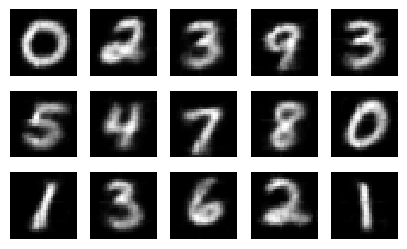

Visualizing encoded and decoded images:


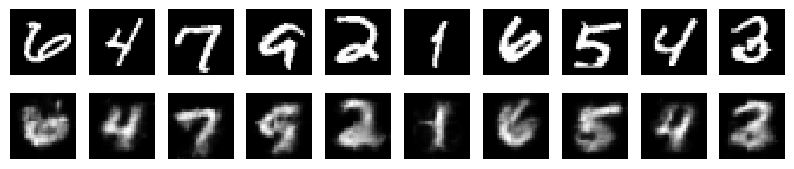

################################################################################
Epoch: 0096/0100
batch: 192: 100%|██████████| 192/192 [00:21<00:00,  8.87it/s]
training set errors:	classification error: 0.023626	autoencoder error: 0.038009	error_1: 0.163076	error_2: 0.770769	total error: 1.444374	accuracy: 0.985021
training takes 21.66 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 20.11it/s]
validation set errors:	classification error: 0.015987	autoencoder error: 0.043390	error_1: 0.218842	error_2: 0.782714	total error: 1.364682	accuracy: 0.989000
################################################################################
Epoch: 0097/0100
batch: 192: 100%|██████████| 192/192 [00:21<00:00,  8.81it/s]
training set errors:	classification error: 0.075603	autoencoder error: 0.038469	error_1: 0.202943	error_2: 0.866515	total error: 2.619988	accuracy: 0.983271
training takes 21.80 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 20.52it/s]
validation set errors:	clas

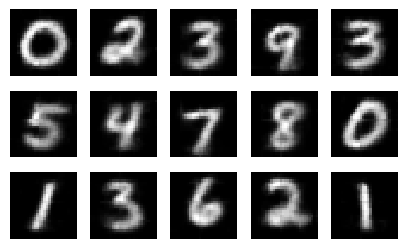

Visualizing encoded and decoded images:


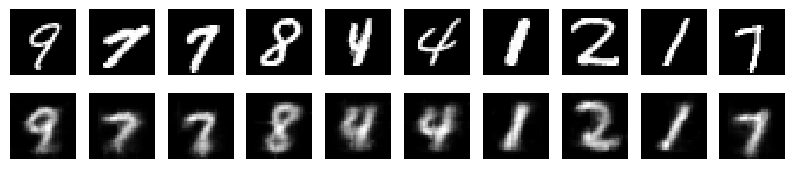

Total taken time 2189.80 seconds.
Optimization Finished!


In [35]:
from tqdm import tqdm, tqdm_notebook

start_time= time.time()

# train the model
for epoch in range(0, training_epochs):
    print_and_write("#"*80, console_log)
    print_and_write("Epoch: %04d" % (epoch+1)+"/%04d" % (training_epochs), console_log)
    n_train_batch = len(train_loader)
    n_val_batch = len(val_loader)
    n_test_batch = len(test_loader)
    start = time.time()

    train_ce, train_ae, train_e1, train_e2, train_te, train_ac = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    
    with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
        for i, batch in enumerate(train_loader):
            batch_x = batch[0]
            batch_y = batch[1]

            # store original batch shape to put it back into this shape after transformation
            batch_shape = batch_x.shape

            # apply elastic transform
            elastic_batch_x = batch_elastic_transform(batch_x.view(batch_size, -1), sigma=sigma, alpha=alpha, height=input_height, width=input_width)
            elastic_batch_x = torch.reshape(torch.tensor(elastic_batch_x), batch_shape)
            elastic_batch_x = elastic_batch_x.to(device)

            batch_y = batch_y.to(device)

            optimizer.zero_grad()        

            pred_y = model.forward(elastic_batch_x)

            # softmax crossentropy loss
            loss_function = torch.nn.CrossEntropyLoss()
            train_ce = loss_function(pred_y, batch_y)

            prototype_distances = model.prototype_layer.prototype_distances
            feature_vectors = model.feature_vectors

            train_e1 = torch.mean(torch.min(list_of_distances(prototype_distances, feature_vectors.view(-1, model.in_channels_prototype)), dim=1)[0])
            train_e2 = torch.mean(torch.min(list_of_distances(feature_vectors.view(-1, model.in_channels_prototype ), prototype_distances), dim=1)[0])

            out_decoder = model.decoder(feature_vectors)
            train_ae = torch.mean(list_of_norms(out_decoder-elastic_batch_x))

            train_te = lambda_class * train_ce +\
                    lambda_1 * train_e1 +\
                    lambda_2 * train_e2 +\
                    lambda_ae * train_ae

            train_te.backward()

            optimizer.step()

            # train accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            train_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

            pbar.set_description('batch: %03d' % (1 + i))
            pbar.update(1)
    
    train_ac /= n_train_batch
    print_and_write("training set errors:"+"\tclassification error: {:.6f}".format(train_ce)+
                    "\tautoencoder error: {:.6f}".format(train_ae)+
                    "\terror_1: {:.6f}".format(train_e1)+
                    "\terror_2: {:.6f}".format(train_e2)+
                    "\ttotal error: {:.6f}".format(train_te)+
                    "\taccuracy: {:.6f}".format(train_ac), console_log)
    print_and_write('training takes {0:.2f} seconds.'.format((time.time() - start)), console_log)
     
    # validation set error terms evaluation
    val_ce, val_ae, val_e1, val_e2, val_te, val_ac = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    
    with tqdm(total=len(val_loader), file=sys.stdout) as pbar:
        for i, batch in enumerate(val_loader):
            batch_x = batch[0]
            batch_y = batch[1]
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            pred_y = model.forward(batch_x)

            loss_function = torch.nn.CrossEntropyLoss()
            val_ce = loss_function(pred_y, batch_y)

            prototype_distances = model.prototype_layer.prototype_distances
            feature_vectors = model.feature_vectors

            val_e1 = torch.mean(torch.min(list_of_distances(prototype_distances, feature_vectors.view(-1, model.in_channels_prototype)), dim=1)[0])
            val_e2 = torch.mean(torch.min(list_of_distances(feature_vectors.view(-1, model.in_channels_prototype ), prototype_distances), dim=1)[0])

            out_decoder = model.decoder(feature_vectors)
            val_ae = torch.mean(list_of_norms(out_decoder-batch_x))

            val_te = lambda_class * val_ce +\
                    lambda_1 * val_e1 +\
                    lambda_2 * val_e2 +\
                    lambda_ae * val_ae
            # validation accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            val_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

            pbar.set_description('batch: %03d' % (1 + i))
            pbar.update(1)
           
    val_ac /= n_val_batch
    # after every epoch, check the error terms on the entire training set
    print_and_write("validation set errors:"+"\tclassification error: {:.6f}".format(val_ce)+
                    "\tautoencoder error: {:.6f}".format(val_ae)+
                    "\terror_1: {:.6f}".format(val_e1)+
                    "\terror_2: {:.6f}".format(val_e2)+
                    "\ttotal error: {:.6f}".format(val_te)+
                    "\taccuracy: {:.6f}".format(val_ac), console_log)
    
    # test set accuracy evaluation
    if (epoch+1) % test_display_step == 0 or epoch == training_epochs - 1:
        test_ac = 0

        for i, batch in enumerate(test_loader):
            batch_x = batch[0]
            batch_y = batch[1]
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            pred_y = model.forward(batch_x)

            # test accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            test_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

        test_ac /= n_test_batch

        print_and_write("test set:", console_log)
        print_and_write("\taccuracy: {:.4f}".format(test_ac), console_log)

    if (epoch+1) % save_step == 0 or epoch == training_epochs - 1:
        # save model states
        model_state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch+1}
        torch.save(model_state, os.path.join(model_folder, model_filename+'%05d.pth' % (epoch+1)))

        # save outputs as images
        # decode prototype vectors
        prototype_imgs = model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()

        # visualize the prototype images
        print_and_write("Visualizing the prototype images:", console_log)
        n_cols = 5
        n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
        g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
        for i in range(n_rows):
            for j in range(n_cols):
                if i*n_cols + j < n_prototypes:
                    b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                                    cmap='gray',
                                    interpolation='none')
                    b[i][j].axis('off')
                    
        plt.savefig(os.path.join(img_folder, 'prototype_result-' + str(epoch+1) + '.png'),
                    transparent=True, bbox_inches='tight', pad_inches=0)
        plt.show()

        plt.close()

        # apply encoding and decoding over a small subset of the training set
        print_and_write("Visualizing encoded and decoded images:", console_log)
        batch_x = []
        for batch in train_loader:
            batch_x = batch[0].to(device)
            break

        examples_to_show = 10
        
        encoded = model.encoder.forward(batch_x[:examples_to_show])
        decoded = model.decoder.forward(encoded)

        decoded = decoded.detach().cpu()
        imgs = batch_x.detach().cpu()

        # compare original images to their reconstructions
        f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
        for i in range(examples_to_show):
            a[0][i].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
            a[0][i].axis('off')
            a[1][i].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
            a[1][i].axis('off')
            
        plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
                    transparent=True,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.show()
        plt.close()
        
print_and_write('Total taken time {0:.2f} seconds.'.format((time.time() - start_time)), console_log)
print_and_write("Optimization Finished!", console_log)
console_log.close()

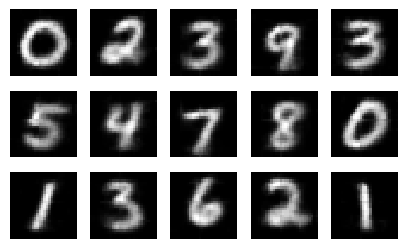

In [36]:
# save outputs as images
# decode prototype vectors
prototype_imgs = model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()
# visualize the prototype images
n_cols = 5
n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        if i*n_cols + j < n_prototypes:
            b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                                    cmap='gray',
                                    interpolation='none')
            b[i][j].axis('off')                   
#plt.savefig(os.path.join(img_folder, 'prototype_result-' + str(epoch+1) + '.png'),
#                    transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

plt.close()

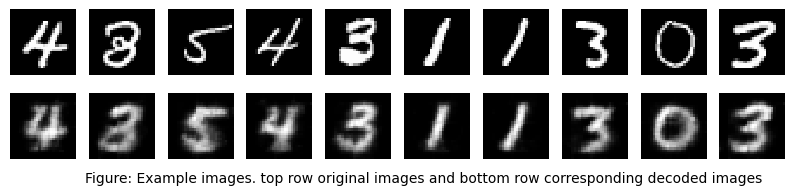

In [37]:
# apply encoding and decoding over a small subset of the training set
batch_x = []
for batch in train_loader:
    batch_x = batch[0].to(device)
    break

examples_to_show = 10
        
encoded = model.encoder.forward(batch_x[:examples_to_show])
decoded = model.decoder.forward(encoded)

decoded = decoded.detach().cpu()
imgs = batch_x.detach().cpu()


# compare original images to their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
    a[0][i].axis('off')
    a[1][i].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
    a[1][i].axis('off')

f.text(.2,.005,'Figure: Example images. top row original images and bottom row corresponding decoded images')
#plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
#                    transparent=True,
#                    bbox_inches='tight',
#                    pad_inches=0)
plt.show()
plt.close()

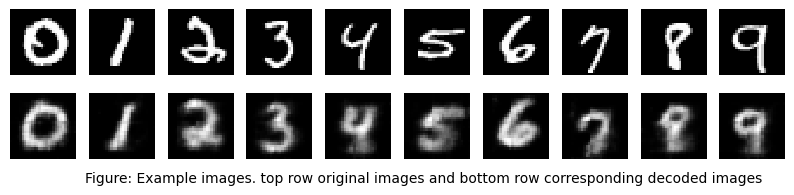

,0,1,2,3,4,5,6,7,8,9
0,14.403075,-12.246263,-1.756597,-3.833767,-8.572647,-4.832079,2.189647,-4.138133,3.800228,-2.275713
1,-4.093843,11.192702,4.521489,-20.145134,0.833568,-7.252180,3.440729,-2.118635,-0.513528,-4.737577
2,-6.117490,-0.136926,11.118856,1.481085,-1.861600,-1.845984,-7.219825,-2.946532,-0.414667,-10.708104
3,-5.751043,-3.300541,0.108105,12.507539,-5.046795,2.842195,-4.029503,-3.226711,-2.217391,-2.830715
4,-6.698019,-0.970786,-11.150936,-4.510831,12.306483,2.178534,1.427215,-0.798985,-0.601728,2.371054
5,-7.696149,-6.398936,-3.339187,-1.310458,-6.361838,12.920380,-1.083155,-7.002042,-0.361857,-0.820341
6,2.680477,-3.198426,-5.315052,-6.411538,-2.592341,1.581746,12.001628,-7.176759,-2.037062,-0.962794
7,-5.555829,3.271895,-0.744193,-1.590177,-3.764170,-1.870267,-2.639141,10.626320,-6.541811,-1.860571
8,-4.216766,-8.407181,-2.345995,-4.365344,-1.667402,-2.339594,-3.067016,-8.702881,9.762996,2.563411
9,-1.281350,-7.048885,-6.695232,-2.732371,1.816299,2.321927,-0.460097,-3.396005,-0.103607,11.583059


In [38]:
import pandas as pd
# apply encoding and decoding over a small subset of the training set
batch_x = []
for batch in train_loader:
    batch_x = batch[0].to(device)
    batch_y = batch[1].to(device)
    break
    
pred_y = model.forward(batch_x)

pred_y_np = pred_y.detach().cpu().numpy() 
batch_y_np = batch_y.detach().cpu().numpy()
labels = []
data = []
idx = []
i = 0
j = 0
for l in batch_y_np:
    if(i==10):
        break
    if l==i:
        labels.append(l)
        data.append(pred_y_np[j])
        idx.append(j)
        i = i+1
    j = j + 1
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
examples_to_show = 10
        
encoded = model.encoder.forward(batch_x)
decoded = model.decoder.forward(encoded)

decoded = decoded.detach().cpu()
imgs = batch_x.detach().cpu() 

# compare original images to their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
j = 0
for i in idx:
    a[0][j].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
    a[0][j].axis('off')
    a[1][j].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
    a[1][j].axis('off')
    j = j + 1
            
#plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
#                    transparent=True,
#                    bbox_inches='tight',
#                    pad_inches=0)
f.text(.2,.005,'Figure: Example images. top row original images and bottom row corresponding decoded images')
plt.show()
plt.close()
    
df = pd.DataFrame(data, labels, classes)
df.style.format(precision=2)
df.style.highlight_max(props='background-color:red;color:white;', axis=1)




# Examples of test

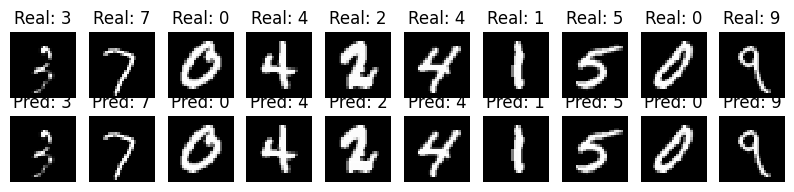

,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9
Example 0,0.000013,0.000180,0.103399,0.868094,0.000292,0.022148,0.000844,0.001773,0.001116,0.002140
Example 1,0.000000,0.000675,0.000082,0.000272,0.000004,0.000012,0.000002,0.998899,0.000000,0.000054
Example 2,0.999997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000
Example 3,0.000000,0.000014,0.000000,0.000000,0.999973,0.000000,0.000003,0.000009,0.000001,0.000000
Example 4,0.000012,0.002731,0.972023,0.022407,0.000004,0.000097,0.000056,0.002474,0.000190,0.000005
Example 5,0.000000,0.000000,0.000000,0.000000,0.999999,0.000001,0.000000,0.000000,0.000000,0.000000
Example 6,0.000000,0.999785,0.000055,0.000000,0.000156,0.000000,0.000001,0.000001,0.000000,0.000002
Example 7,0.000000,0.000000,0.000000,0.000000,0.000000,0.999999,0.000000,0.000000,0.000000,0.000001
Example 8,0.999683,0.000000,0.000013,0.000000,0.000000,0.000000,0.000120,0.000000,0.000184,0.000000
Example 9,0.000000,0.000000,0.000007,0.000008,0.000013,0.000032,0.000000,0.000000,0.000027,0.999912


In [44]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

# Obtener un batch de test
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Obtener un batch del conjunto de test
batch_x, batch_y = next(iter(test_loader))
batch_x, batch_y = batch_x.to(device), batch_y.to(device)

# Hacer predicciones
with torch.no_grad():
    pred_y = model(batch_x)  # No usar forward() directamente

# Convertir a numpy para análisis
pred_y_np = pred_y.cpu().numpy()
batch_y_np = batch_y.cpu().numpy()

# Obtener probabilidades con softmax
probabilities = torch.nn.functional.softmax(pred_y, dim=1).cpu().numpy()

# Seleccionar ejemplos a mostrar
examples_to_show = 10
fig, axes = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))

for i in range(examples_to_show):
    # Mostrar imagen original
    axes[0, i].imshow(batch_x[i].cpu().squeeze(), cmap="gray", interpolation="none")
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Real: {batch_y_np[i]}")
    
    # Mostrar la clase predicha
    predicted_class = pred_y_np[i].argmax()
    axes[1, i].imshow(batch_x[i].cpu().squeeze(), cmap="gray", interpolation="none")
    axes[1, i].axis("off")
    axes[1, i].set_title(f" \nPred: {predicted_class}")

plt.show()

# Crear un DataFrame con probabilidades
df = pd.DataFrame(probabilities[:examples_to_show], 
                  index=[f"Example {i}" for i in range(examples_to_show)], 
                  columns=[f"Class {i}" for i in range(probabilities.shape[1])])


# Resaltar las predicciones más altas
df = df.style.highlight_max(axis=1, props="background-color: red; color: white;")
df
